**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [17]:
# write your code here

import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from IPython.display import display, Math
from types import SimpleNamespace
from scipy.optimize import minimize, minimize_scalar, brentq

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

#Problem 1
#from main import problem1

# Problem 2
from Labor_Cost_class import Labor_Cost_class

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from types import SimpleNamespace
import time
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from IPython.display import display, Math


class problem1():
    def __init__(self,do_print=True):
        """ create the model """
        self.par = SimpleNamespace()
        self.sol = SimpleNamespace()
        
        self.setup()

    def setup(self):
        """ baseline parameters """

        par = self.par
        sol = self.sol
        
        #Set up parameters
        par.alpha=0.5
        par.kappa=1.0
        par.nu = 1/(2*16**2)
        par.w = 1.0
        par.tau = 0.3
        par.G = 1.0   
        
        par.with_G = False
        
        par.sigma = 1.001
        par.rho=1.0001
        par.epsilon = 1.0
            
        par.simT = 50 # length of simulation
    
    def utility(self,L):

        par = self.par
        
        if par.with_G == False:
            C = par.kappa+(1-par.tau)*par.w*L
            utility = np.log(C**par.alpha*par.G**(1-par.alpha))-par.nu*(L**2/2)
        
        elif par.with_G == True:
            C = par.kappa+(1-par.tau)*par.w*L
            G = par.tau*par.w*L*((1-par.tau)*par.w)
            utility = np.log(C**par.alpha*G**(1-par.alpha))-par.nu*(L**2/2)
        
          
        return utility
        
    def solve(self):
        
        par = self.par
        
        opt = SimpleNamespace()
        
        # creating objective function for optimize
        def obj(x):
            return -self.utility(x[0])
        
        #Optimize
        res = optimize.minimize(obj,x0 = (12),method='BFGS',tol=1e-10)
        
        #Saving results
        opt.L = res.x[0]
        
        return opt
    
    def analytical_sol(self,w):
    
        par = self.par
        
        w_tau = (1-par.tau)*w
        
        L = (-par.kappa+np.sqrt(par.kappa**2+4*(par.alpha/par.nu)*w_tau**2))/(2*w_tau)
        
        return L

    def utility_general(self,L):
    
        par = self.par
        
        C = par.kappa+(1-par.tau)*par.w*L
        G = par.G
        
        first = par.alpha*C**((par.sigma-1)/par.sigma)
        second = (1-par.alpha)*G**((par.sigma-1)/(par.sigma))
        
        comb = ((first+second)**(par.sigma/(1-par.sigma))**(1-par.rho)-1)/(1-par.rho)
        last = par.nu*(L**(1+par.epsilon)/(1+par.epsilon))
                                         
        utility = comb - last
        
        return utility
    
    def solve_general(self):
        
        par = self.par
        sol = self.sol
        
        opt = SimpleNamespace()
        
        # creating objective function for optimize
        def obj(x):
            return -self.utility_general(x)
        
        #Optimize
        res = minimize_scalar(obj, bounds=(0, 24), method='bounded')
        
        #Saving results
        opt.L = res.x
        sol.L = res.x
        
        return opt
    
    
    def solve_q5(self):
        
        def obj(G):
            par.G = G
            model.solve_general()
        
            return par.G-par.tau*par.w*sol.L
    
        res = brentq(obj,-100,100)
    
        return res
    
    
    

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [7]:
model_q1 = problem1()

par = model_q1.par # SimpeNamespace

#Check for G=1
par.G = 1.0

opt = model_q1.solve()
if round(opt.L,2) == round(model_q1.analytical_sol(1),2):
    print('True for G=1')
    
#Check for G=2
par.G = 2.0
opt = model_q1.solve()
if round(opt.L,2) == round(model_q1.analytical_sol(1),2):
    print('True for G=2')



True for G=1
True for G=2


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [ ]:
# write your code here




We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [ ]:
# write your code here



**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

We assume that L does not change with government spending, thus we solve by finding the optimal wage for a given G, and then use that to find the optimal tax rate. The inution could be that the goverment sends out money at the end of the year, and the agents do not know how much before they choose their optimal labor.

In [8]:
# write your code here
model_q4 = problem1()

par = model_q4.par # SimpeNamespace

def obj(x):

    par.tau = x # Change tax rate
    par.with_G = False 
    
    L = model_q4.solve().L #Getting optimal labour supply
    
    par.with_G = True # Account for G in the utiltiy
    
    return -model_q4.utility(L) #Finding  utility


#Finding the optimal tax rate
res = minimize_scalar(obj, bounds=(0, 1), method='bounded')

print('The optimal tax-rate is: ' + str(round(res.x,2)))

optimal_tau = res.x

The optimal tax-rate is: 0.34


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [33]:
model_q5 = problem1()

par = model_q5.par
sol = model_q5.sol

def obj(G):
    par.G = G
    model_q5.solve_general()
        
    return par.G-par.tau*par.w*sol.L

par.tau = optimal_tau
par.w = 1
par.G = 1

#Set 1
par.sigma = 1.001
par.rho = 1.001
par.epsilon = 1.0
    
res_1 = brentq(obj,-100,100)

# Set 2
par.sigma = 1.5
par.rho = 1.5
par.epsilon = 1.0

res_2 = brentq(obj,-100,100)


# Answers 

print(res_1)


1.5686233183487275e-06


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [15]:
model_q6 = problem1()

#Set 1 
par = model_q6.par # SimpeNamespace

def obj(x):
    par.tau = x #Change tax rate
    L = model_q4.solve_general().L #Getting optimal labour supply
    return -model_q4.utility_general(L) #Finding  utility


#Finding the optimal tax rate
res = minimize_scalar(obj, bounds=(0, 1), method='bounded')

print('The optimal tax-rate for set 1 is: ' + str(round(res.x,2)))


#Set 2


The optimal tax-rate for set 1 is: 1.0


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [4]:
model = Labor_Cost_class()
par = model.par
sim = model.sim

In [5]:
par.kappa = 1.0
model.compare_num_ana()

par.kappa = 2.0
model.compare_num_ana()

# resetting kappa
par.kappa = 1.0

Numerical solution with par.kappa=1.0: 0.250000
Analytical solution with par.kappa=1.0: 0.250000
Numerical solution with par.kappa=2.0: 1.000000
Analytical solution with par.kappa=2.0: 1.000000


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [6]:
par.K = 1
model.H()
print(f'Profit with {par.K=}: {sim.H:.4f}')

par.K = 10
model.H()
print(f'Profit with {par.K=}: {sim.H:.4f}')

par.K = 100
model.H()
print(f'Profit with {par.K=}: {sim.H:.4f}')

par.K = 1_000
model.H()
print(f'Profit with {par.K=}: {sim.H:.4f}')

par.K = 2_000
model.H()
print(f'Profit with {par.K=}: {sim.H:.4f}')

par.K = 5_000
model.H()
print(f'Profit with {par.K=}: {sim.H:.4f}')

Profit with par.K=1: 34.6697
Profit with par.K=10: 29.8006
Profit with par.K=100: 27.9806
Profit with par.K=1000: 28.5633
Profit with par.K=2000: 28.3834
Profit with par.K=5000: 28.4588


We choose $K$ large enough to ensure the variability of draws. The difference for different values of $K$ is illustrated above. We settle for $K=10,000$

In [7]:
par.K = 10_000
par.delta = 0.00
model.H()
print(f'Profit with {par.delta=}: {sim.H:.4f}')

Profit with par.delta=0.0: 27.6197


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [8]:
par.delta = 0.05
model.H()
print(f'Profit with {par.delta=}: {sim.H:.4f}')

Profit with par.delta=0.05: 28.3804


Increasing $\Delta$ improves profitability, as labor adjustments now are costly, due to $\iota>0$

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [9]:
x_ = np.linspace(0.,0.5,10)
yy = np.zeros_like(x_)
for i in range(10):
    par.seed = True
    par.delta = x_[i]
    model.H()
    yy[i] = sim.H

In [10]:
# function maximizing ex-ante profits by choosing delta
def obj(delta,model):

    par = model.par
    sim = model.sim

    par.delta = delta

    model.H()

    return -sim.H

res = minimize(obj,x0=0.1,args=(model,),method='Nelder-Mead')

In [11]:
print(f'Profit maximizing choice of delta: {res.x.item():.4f}')
print(f'Which gives the following ex-ante profit: {-res.fun.item():.4f}')

Profit maximizing choice of delta: 0.0752
Which gives the following ex-ante profit: 28.4102


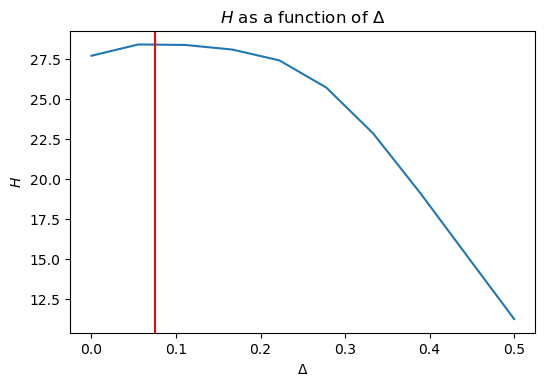

In [12]:
fig,ax = plt.subplots(dpi=100)
ax.plot(x_,yy)
ax.set_ylabel('$H$')
ax.set_xlabel('$\Delta$')
ax.set_title('$H$ as a function of $\Delta$')
ax.axvline(res.x,c='red')

plt.show()

We find the optimal value of $\Delta$ to be 0.075, at first ex-ante profits are increasing in $\Delta$, as the loss due to sluggishness in labor adjustment is offset by the gain in due to saved labor adjustment costs.

When $\Delta$ takes on too high values, the firm will adjust their labor less frequently, proving to be suboptimal.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



Our alternative policy, is for the firm adjust it labor, if the periodwise profit is larger with $\ell^{\ast}_{t}$ than $\ell_{t-1}$

$$

$$

$$
\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\kappa_{t}{\ell^{\ast}_{t}}^{1-\eta}-w\ell^{\ast}_{t}-\iota >\kappa_{t}{\ell_{t-1}}^{1-\eta}-w\ell_{t-1}\\
\ell_{t-1} & \text{else }
\end{cases}
$$

In [13]:
# change labor adjustment policy
par.ell_rule = 'new'
model.H()

print(f'Profit with new adjustment policy: {sim.H:.4f}')

Profit with new adjustment policy: 28.4125


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [14]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1


A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [19]:
# write your code here
k = 0
K = 1_000
K_ = 10

# drawing x's in advance to ensure the random values are used in q1 and q2 for comparison
draws = np.random.uniform(-600,600,size=(K,2))

while k < K:
    # a
    # xk = np.random.uniform(-600,600,size=2)
    xk = draws[k]

    # b
    if k>=K_:

        # c
        chi_k = 0.5*2/(1+np.exp((k-K_)/100))

        # d
        x_k0 = chi_k*xk + (1-chi_k)*x_star

    # e
    if k == 0:
        x_k0 = xk
    res = minimize(griewank,x0=x_k0,method='BFGS',tol=1e-8)
    x_kstar = res.x

    # f
    if k == 0:
        x_star = x_kstar

    if griewank(x_kstar)<griewank(x_star):
        x_star = x_kstar

    fxstar = griewank(x_star)

    if fxstar< 1e-8:
        print(f'Iterations for convergence {k}')
        print(f'Terminal function value {fxstar:.10f}')
        break
    else:
        k += 1

Iterations for convergence 251
Terminal function value 0.0000000000


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [20]:
# write your code here
# write your code here
k = 0
K = 1_000
K_ = 100
while k < K:
    # a
    # xk = np.random.uniform(-600,600,size=2)
    xk = draws[k]

    # b
    if k>=K_:

        # c
        chi_k = 0.5*2/(1+np.exp((k-K_)/100))

        # d
        x_k0 = chi_k*xk + (1-chi_k)*x_star

    # e
    if k == 0:
        x_k0 = xk
    res = minimize(griewank,x0=x_k0,method='BFGS',tol=1e-8)
    x_kstar = res.x

    # f
    if k == 0:
        x_star = x_kstar

    if griewank(x_kstar)<griewank(x_star):
        x_star = x_kstar

    fxstar = griewank(x_star)

    if fxstar< 1e-8:
        print(f'Iterations for convergence {k}')
        print(f'Terminal function value {fxstar:.10f}')
        break
    else:
        k += 1

Iterations for convergence 309
Terminal function value 0.0000000000
